In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


## Going from slow waves to a wake region

In [2]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [3]:
HET_REGION = 0

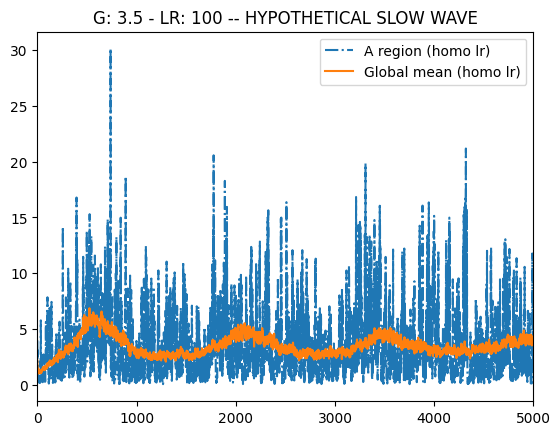

In [4]:

plt.plot(rates_dyn[HET_REGION,:], label="A region (homo lr)", linestyle="-.")
plt.plot(np.mean(rates_dyn,axis=0), label="Global mean (homo lr)", linestyle="-")
plt.xlim([0,5000])
plt.title(f"G: {params['G']} - LR: {LR} -- HYPOTHETICAL SLOW WAVE")
plt.legend()
plt.show()

In [5]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 10000
params_heter['lr_vector'][HET_REGION] = HET_LR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][HET_REGION] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


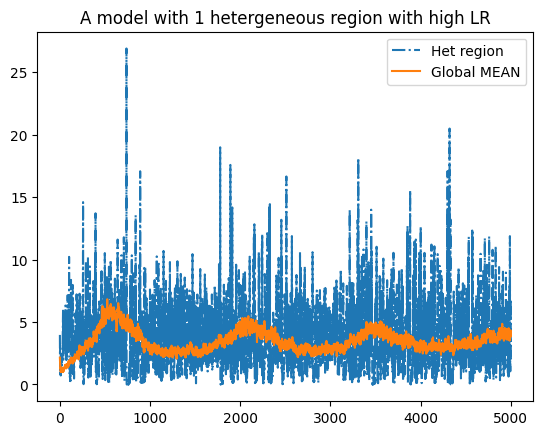

In [6]:
plt.plot(rates_heter[HET_REGION,:5000], label="Het region", linestyle="-.")
plt.plot(np.mean(rates_heter[np.arange(N) != HET_REGION, :5000], axis=0), label="Global MEAN", linestyle="-")
plt.title("A model with 1 hetergeneous region with high LR")
plt.legend()
plt.show()

In [7]:
def get_autcorr(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = rates - np.mean(rates)    
    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    return autocorr



In [8]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_hete_restreg = get_autcorr(np.mean(rates_heter[1:],axis=0))


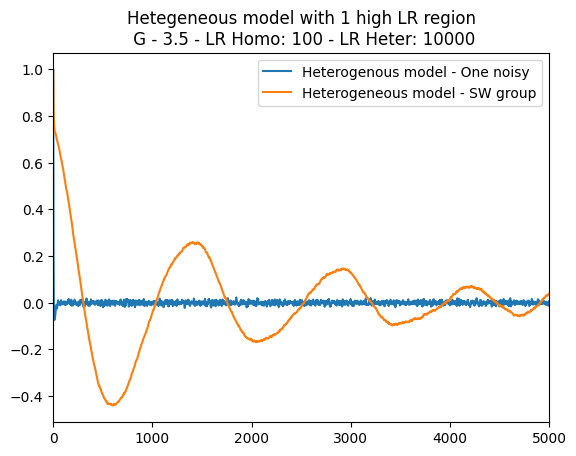

In [9]:
lags = np.arange(0,len(autocorr_hete_restreg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - One noisy')
plt.plot(lags,autocorr_hete_restreg,label='Heterogeneous model - SW group')

plt.xlim([0,5000])
plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Comparing a region in two different models with global SW

In [10]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [11]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 10000
params_heter['lr_vector'][HET_REGION] = HET_LR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][HET_REGION] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


In [12]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_homo_onereg = get_autcorr(rates_dyn[HET_REGION,:])


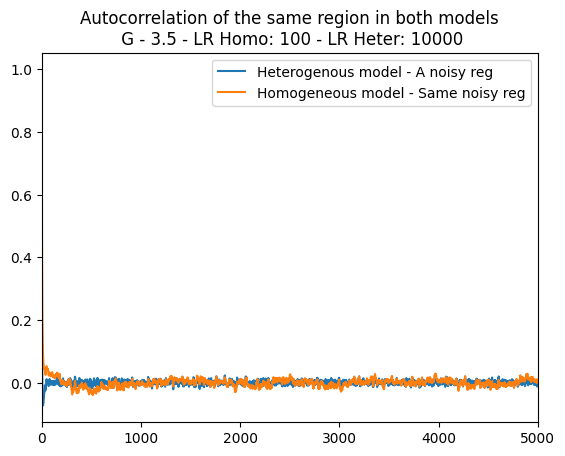

In [13]:
lags = np.arange(0,len(autocorr_homo_onereg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - A noisy reg')
plt.plot(lags,autocorr_homo_onereg,label='Homogeneous model - Same noisy reg')

plt.xlim([0,5000])
plt.title(f"Autocorrelation of the same region in both models\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Going from Awake regime to SW region

In [40]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [41]:
HET_REGION = 0

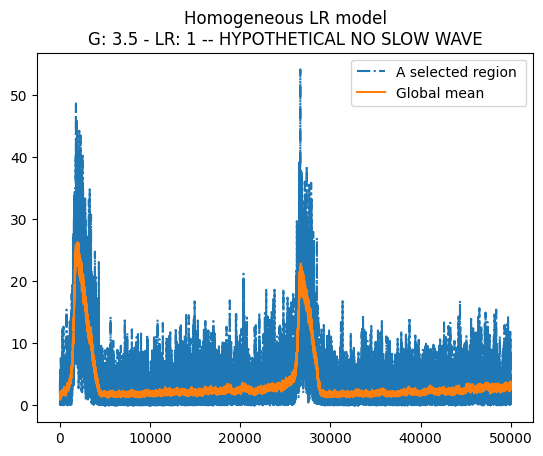

In [43]:

plt.plot(rates_dyn[HET_REGION,:], label="A selected region ", linestyle="-.")
plt.plot(np.mean(rates_dyn,axis=0), label="Global mean ", linestyle="-")

plt.title(f"Homogeneous LR model\nG: {params['G']} - LR: {LR} -- HYPOTHETICAL NO SLOW WAVE")
plt.legend()
plt.show()

In [44]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 100
params_heter['lr_vector'][HET_REGION] = HET_LR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][HET_REGION] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


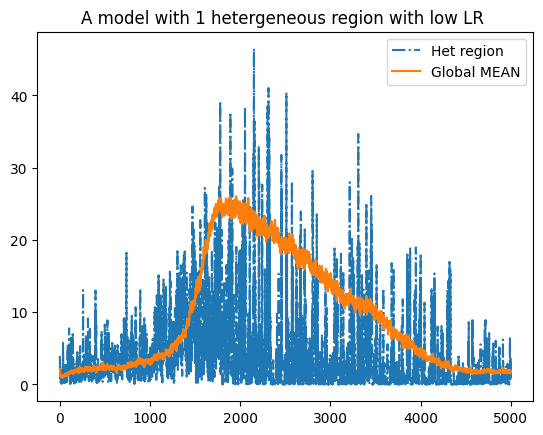

In [45]:
plt.plot(rates_heter[HET_REGION,:5000], label="Het region", linestyle="-.")
plt.plot(np.mean(rates_heter[np.arange(N) != HET_REGION, :5000], axis=0), label="Global MEAN", linestyle="-")
#plt.ylim([0,12])
plt.title("A model with 1 hetergeneous region with low LR ")
plt.legend()
plt.show()

In [46]:
def get_autcorr(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = rates - np.mean(rates)    
    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    return autocorr



In [47]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_hete_restreg = get_autcorr(np.mean(rates_heter[1:],axis=0))


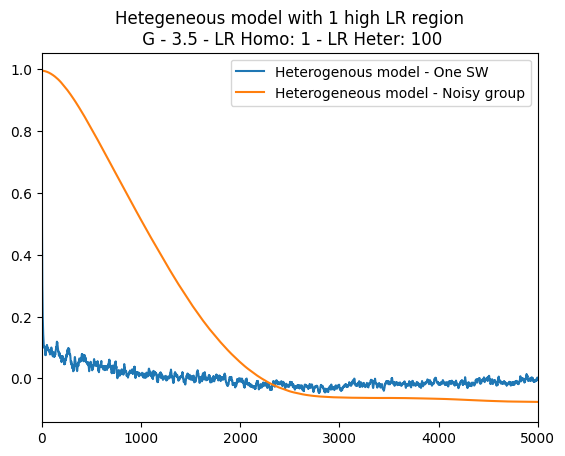

In [48]:
lags = np.arange(0,len(autocorr_hete_restreg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - One SW')
plt.plot(lags,autocorr_hete_restreg,label='Heterogeneous model - Noisy group')

plt.xlim([0,5000])
plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_LR}")
plt.legend()

## Comparing a region in two different models

In [52]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [53]:

params_heter = params.copy()
params_heter['lr_vector'] = np.ones(N)*LR
HET_LR = 100
params_heter['lr_vector'][HET_REGION] = HET_LR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][HET_REGION] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


In [24]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_homo_onereg = get_autcorr(rates_dyn[HET_REGION,:])


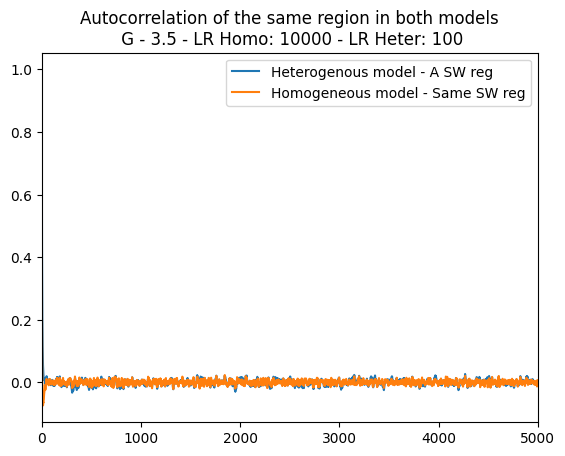

In [ ]:
lags = np.arange(0,len(autocorr_homo_onereg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - A SW reg')
plt.plot(lags,autocorr_homo_onereg,label='Homogeneous model - Same SW reg')

plt.xlim([0,5000])
plt.title(f"Autocorrelation of the same region in both models\n G - {params['G']} - LR Homo: {LR} - LR Heter: {HET_}")
plt.legend()

## Groups of heterogeneous region in a Noisy context

In [94]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 1000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [95]:
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-100]


In [96]:

params_heter = params.copy()
HETEROGENITY_VECTOR = np.ones(N)*LR
HET_LR = 100
HETEROGENITY_VECTOR[most_connected] = HET_LR
params_heter['lr_vector'] = HETEROGENITY_VECTOR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][most_connected] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


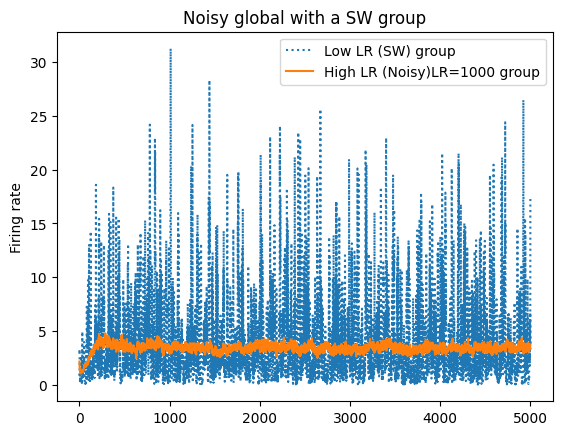

In [114]:
not_most_connected = np.setdiff1d(np.arange(N),most_connected)
plt.plot(np.mean(rates_heter[most_connected,:5000],axis=0), label="Low LR (SW) group", linestyle=":")
plt.plot(np.mean(rates_heter[not_most_connected,:5000],axis=0), label=f"High LR (Noisy)LR={LR} group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.title("Noisy global with a SW group")
plt.legend()
plt.show()

In [115]:

autocorr_most_connected = get_autcorr(np.mean(rates_heter[most_connected,5000:],axis=0))
autocorr_not_most_connected = get_autcorr(np.mean(rates_heter[not_most_connected,5000:],axis=0))


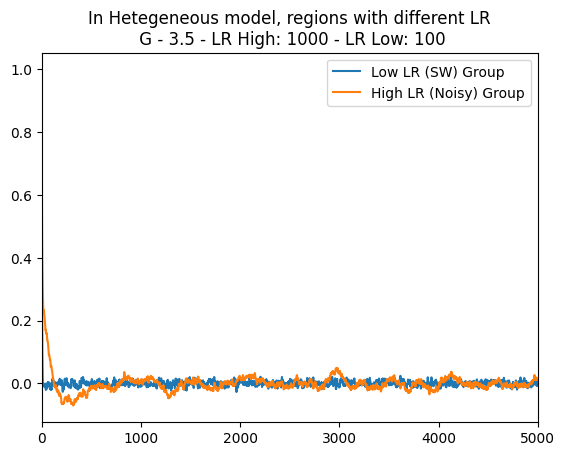

In [116]:
lags = np.arange(0,len(autocorr_most_connected))
plt.plot(lags, autocorr_most_connected,label='Low LR (SW) Group')
plt.plot(lags,autocorr_not_most_connected,label='High LR (Noisy) Group')

plt.xlim([0,5000])
plt.title(f"In Hetegeneous model, regions with different LR\n G - {params['G']} - LR High: {LR} - LR Low: {HET_LR}")
plt.legend()

## Making a smart selection of Low LR group

In [117]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 1000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [118]:
from bct import score_wu, rich_club_wu

In [119]:
node_strength = np.sum(C,axis=0)

In [146]:
score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 

In [153]:
highest_score = score_idxs[-5]
params_heter = params.copy()
HETEROGENITY_VECTOR = np.ones(N)*LR
HET_LR = 100
HETEROGENITY_VECTOR[highest_score] = HET_LR
params_heter['lr_vector'] = HETEROGENITY_VECTOR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][highest_score] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


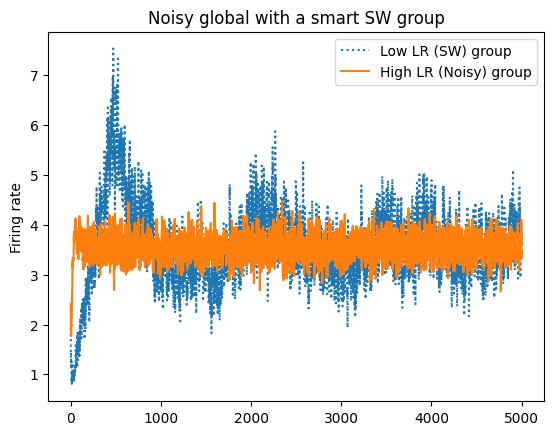

In [154]:
not_highest_score = np.setdiff1d(np.arange(N),highest_score)
plt.plot(np.mean(rates_heter[highest_score,:5000],axis=0), label="Low LR (SW) group", linestyle=":")
plt.plot(np.mean(rates_heter[not_highest_score,:5000],axis=0), label="High LR (Noisy) group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.title("Noisy global with a smart SW group")
plt.legend()
plt.show()

In [155]:


autocorr_highest_score = get_autcorr(np.mean(rates_heter[highest_score,5000:],axis=0))
autocorr_not_highest_score = get_autcorr(np.mean(rates_heter[not_highest_score,5000:],axis=0))


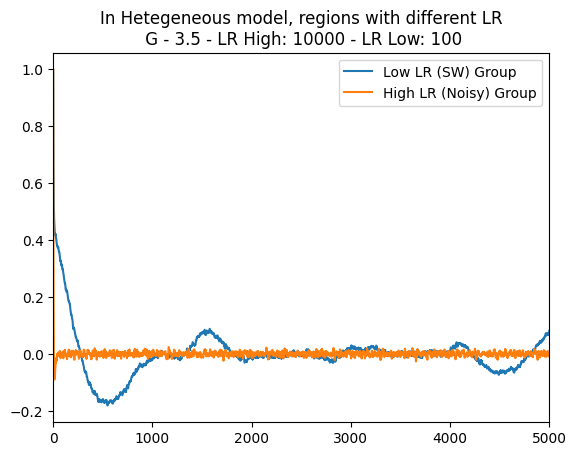

In [156]:
lags = np.arange(0,len(autocorr_highest_score))
plt.plot(lags, autocorr_highest_score,label='Low LR (SW) Group')
plt.plot(lags,autocorr_not_highest_score,label='High LR (Noisy) Group')

plt.xlim([0,5000])
plt.title(f"In Hetegeneous model, regions with different LR\n G - {params['G']} - LR High: {LR} - LR Low: {HET_LR}")
plt.legend()

# A RANDOM SELECTIN OF NODES TO HAVE LOW LR

In [125]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 1000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [126]:
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 100 random regions
np.random.seed(1)
random_connected = np.random.choice(np.arange(N),100,replace=False)


In [127]:

params_heter = params.copy()
HETEROGENITY_VECTOR = np.ones(N)*LR
HET_LR = 100
HETEROGENITY_VECTOR[random_connected] = HET_LR
params_heter['lr_vector'] = HETEROGENITY_VECTOR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][random_connected] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


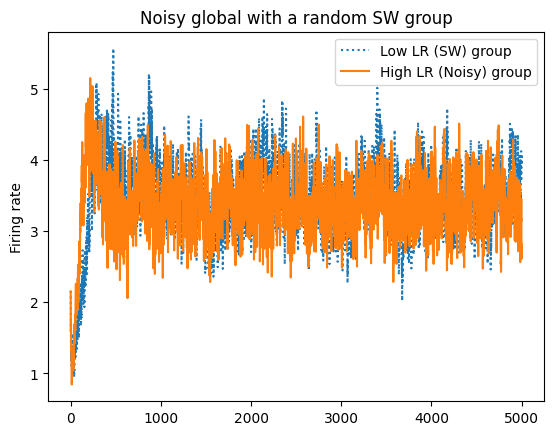

In [128]:
not_random_connected = np.setdiff1d(np.arange(N),random_connected)
plt.plot(np.mean(rates_heter[random_connected,:5000],axis=0), label="Low LR (SW) group", linestyle=":")
plt.plot(np.mean(rates_heter[not_random_connected,:5000],axis=0), label="High LR (Noisy) group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.title("Noisy global with a random SW group")
plt.legend()
plt.show()

In [129]:

autocorr_random_connected = get_autcorr(np.mean(rates_heter[random_connected,5000:],axis=0))
autocorr_not_random_connected = get_autcorr(np.mean(rates_heter[not_random_connected,5000:],axis=0))


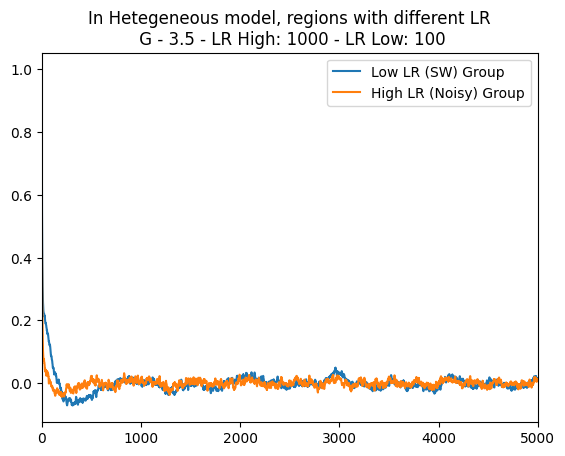

In [130]:
lags = np.arange(0,len(autocorr_random_connected))
plt.plot(lags, autocorr_random_connected,label='Low LR (SW) Group')
plt.plot(lags,autocorr_not_random_connected,label='High LR (Noisy) Group')

plt.xlim([0,5000])
plt.title(f"In Hetegeneous model, regions with different LR\n G - {params['G']} - LR High: {LR} - LR Low: {HET_LR}")
plt.legend()

## Breaking brain in two hemispheres

In [135]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_vector'] = np.ones(N)*LR
params['taoj_vector'] =  np.ones(N)*DECAY
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [136]:
half_brain = np.arange(100)

In [137]:

params_heter = params.copy()
HETEROGENITY_VECTOR = np.ones(N)*LR
HET_LR = 100
HETEROGENITY_VECTOR[half_brain] = HET_LR
params_heter['lr_vector'] = HETEROGENITY_VECTOR
HET_DECAY = np.exp(a+np.log(HET_LR)*b)
params_heter['taoj_vector'] =  np.ones(N)*DECAY
params_heter['taoj_vector'][half_brain] = HET_DECAY
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


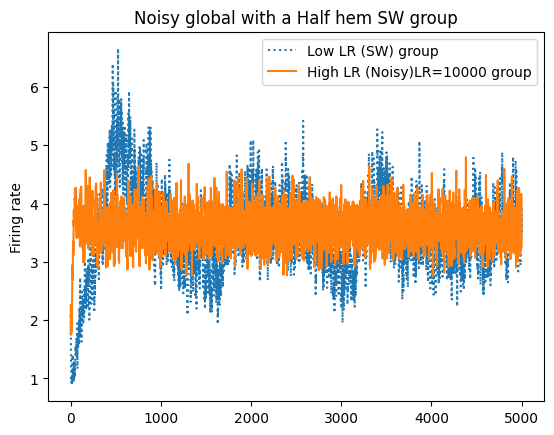

In [142]:
not_half_brain = np.setdiff1d(np.arange(N),half_brain)
plt.plot(np.mean(rates_heter[half_brain,:5000],axis=0), label="Low LR (SW) group", linestyle=":")
plt.plot(np.mean(rates_heter[not_half_brain,:5000],axis=0), label=f"High LR (Noisy)LR={LR} group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.title("Noisy global with a Half hem SW group")
plt.legend()
plt.show()

In [139]:

autocorr_half_brain = get_autcorr(np.mean(rates_heter[half_brain,5000:],axis=0))
autocorr_not_half_brain = get_autcorr(np.mean(rates_heter[not_half_brain,5000:],axis=0))


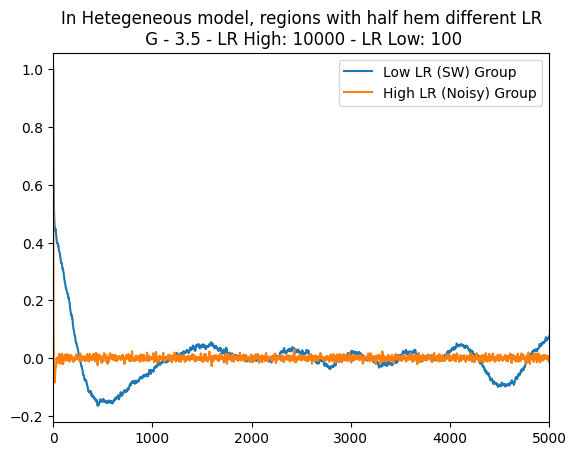

In [145]:
lags = np.arange(0,len(autocorr_half_brain))
plt.plot(lags, autocorr_half_brain,label='Low LR (SW) Group')
plt.plot(lags,autocorr_not_half_brain,label='High LR (Noisy) Group')

plt.xlim([0,5000])
plt.title(f"In Hetegeneous model, regions with half hem different LR\n G - {params['G']} - LR High: {LR} - LR Low: {HET_LR}")
plt.legend()